In [43]:
# Import libraries
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import fasttext
import pickle

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# Read data

In [2]:
# Read data
train = pd.read_csv("train.txt",delimiter=';',header=None,names=['sentence','label'])
test = pd.read_csv("test.txt",delimiter=';',header=None,names=['sentence','label'])

In [3]:
df = pd.concat([train,test])
print(df.shape)
df.head()

(18000, 2)


,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
print(df['label'].value_counts())
print('\n')
print(df['label'].value_counts(normalize=True))

joy         6057
sadness     5247
anger       2434
fear        2161
love        1463
surprise     638
Name: label, dtype: int64


joy         0.336500
sadness     0.291500
anger       0.135222
fear        0.120056
love        0.081278
surprise    0.035444
Name: label, dtype: float64


In [5]:
print(train.shape)
print(train['label'].value_counts(normalize=True))

(16000, 2)
joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: label, dtype: float64


In [6]:
print(test.shape)
print(test['label'].value_counts(normalize=True))

(2000, 2)
joy         0.3475
sadness     0.2905
anger       0.1375
fear        0.1120
love        0.0795
surprise    0.0330
Name: label, dtype: float64


# Preprocess text

In [7]:
def clean_data(data):
    
    stop_words = set(stopwords.words('english'))
    text_clean = []
    new_data = pd.DataFrame({'sentence': data.sentence, 'label': data.label})
    
    new_data['sentence'] = data.apply(lambda r: ' '.join(w.lower() for w in r['sentence'].split() 
                                                         if (w.lower() not in stop_words) & 
                                                         (w.isalpha())),axis=1)
    new_data['sentence'] = new_data[new_data['sentence'] != '']
    new_data = new_data.dropna()

    return new_data

In [8]:
def extract_features(train_set, test_set, ngram):

    tfidf=TfidfVectorizer(use_idf=True, max_df=0.95, ngram_range=ngram)
    tfidf.fit_transform(train_set['sentence'].values)

    train_tfidf=tfidf.transform(train_set['sentence'].values)
    test_tfidf=tfidf.transform(test_set['sentence'].values)

    return train_tfidf,test_tfidf,tfidf

In [9]:
df_clean = clean_data(df)
df_clean.to_csv('data_clean.csv')

training_df, testing_df = train_test_split(df_clean[['sentence', 'label']].dropna(), 
                                               test_size = 0.2, random_state = 2020)

X_train, X_test, tfidf_vectorizer = extract_features(training_df, testing_df, (1,2))
y_train = training_df['label'].values
y_test = testing_df['label'].values

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [10]:
np.mean([len(i) for i in df_clean.sentence])

61.62005555555555

# Fit models

## Logistic regression

In [32]:
def predict_evaluate(model, test_tfidf, test_y):
    prediction = model.predict(test_tfidf)
    print(classification_report(test_y, prediction))
    return prediction

In [11]:
lr1 = LogisticRegression(random_state=2020, C=15, penalty='l2', max_iter=1000, verbose=1)
lr1_classifier = OneVsRestClassifier(lr1)
model_lr1 = lr1_classifier.fit(X_train,y_train)

lr1_pred = predict_evaluate(model_lr1, X_test, y_test)
# print('Accuracy:', accuracy_score(Y_test, Y_pred))
# print('F1-score:', f1_score(Y_test, Y_pred, average='micro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

       anger       0.93      0.88      0.90       509
        fear       0.89      0.84      0.87       438
         joy       0.90      0.94      0.92      1220
        love       0.83      0.72      0.77       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.82      0.66      0.73       128

    accuracy                           0.90      3600
   macro avg       0.88      0.83      0.85      3600
weighted avg       0.90      0.90      0.90      3600



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


In [12]:
lr2 = LogisticRegression(random_state=2020, C=5, penalty='l2', max_iter=1000, verbose=1)
lr2_classifier = OneVsRestClassifier(lr2)
model_lr2 = lr2_classifier.fit(X_train,y_train)

lr2_pred = predict_evaluate(model_lr2, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

       anger       0.92      0.85      0.88       509
        fear       0.88      0.82      0.85       438
         joy       0.88      0.95      0.91      1220
        love       0.85      0.69      0.77       280
     sadness       0.91      0.97      0.94      1025
    surprise       0.85      0.62      0.71       128

    accuracy                           0.89      3600
   macro avg       0.88      0.82      0.84      3600
weighted avg       0.89      0.89      0.89      3600



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [13]:
lr3 = LogisticRegression(random_state=2020, C=30, penalty='l2', max_iter=1000, verbose=1)
lr3_classifier = OneVsRestClassifier(lr3)
model_lr3 = lr3_classifier.fit(X_train,y_train)

lr3_pred = predict_evaluate(model_lr3, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

       anger       0.93      0.89      0.91       509
        fear       0.89      0.84      0.87       438
         joy       0.90      0.94      0.92      1220
        love       0.83      0.73      0.78       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.81      0.67      0.74       128

    accuracy                           0.90      3600
   macro avg       0.88      0.84      0.86      3600
weighted avg       0.90      0.90      0.90      3600



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


In [14]:
filepath = "logistic_best.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(model_lr3, file)

## SVM

In [33]:
svm1 = LinearSVC(random_state=2020, C=1, loss='squared_hinge', max_iter=1000)
model_svm1 = svm1.fit(X_train,y_train)

svm1_pred = predict_evaluate(model_svm1, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.89      0.90       509
        fear       0.89      0.85      0.87       438
         joy       0.91      0.94      0.93      1220
        love       0.83      0.76      0.79       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.83      0.70      0.76       128

    accuracy                           0.91      3600
   macro avg       0.88      0.85      0.87      3600
weighted avg       0.90      0.91      0.90      3600



In [34]:
svm2 = LinearSVC(random_state=2020, C=50, loss='squared_hinge', max_iter=1000)
model_svm2 = svm2.fit(X_train,y_train)

svm2_pred = predict_evaluate(model_svm2, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.89      0.90       509
        fear       0.90      0.85      0.87       438
         joy       0.92      0.94      0.93      1220
        love       0.83      0.78      0.80       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.78      0.73      0.76       128

    accuracy                           0.91      3600
   macro avg       0.88      0.86      0.87      3600
weighted avg       0.91      0.91      0.91      3600



In [35]:
svm3 = LinearSVC(random_state=2020, C=50, loss='hinge', max_iter=1000)
model_svm3 = svm3.fit(X_train,y_train)

svm3_pred = predict_evaluate(model_svm3, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.89      0.90       509
        fear       0.90      0.84      0.87       438
         joy       0.92      0.94      0.93      1220
        love       0.82      0.78      0.80       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.80      0.73      0.76       128

    accuracy                           0.91      3600
   macro avg       0.88      0.86      0.87      3600
weighted avg       0.90      0.91      0.90      3600



In [36]:
svm4 = LinearSVC(random_state=2020, C=1, loss='hinge', max_iter=1000)
model_svm4 = svm4.fit(X_train,y_train)

svm4_pred = predict_evaluate(model_svm4, X_test, y_test)

              precision    recall  f1-score   support

       anger       0.92      0.90      0.91       509
        fear       0.88      0.85      0.86       438
         joy       0.92      0.94      0.93      1220
        love       0.83      0.75      0.79       280
     sadness       0.92      0.96      0.94      1025
    surprise       0.84      0.65      0.73       128

    accuracy                           0.91      3600
   macro avg       0.88      0.84      0.86      3600
weighted avg       0.90      0.91      0.90      3600



In [37]:
filepath = "svm_best.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(model_svm2, file)

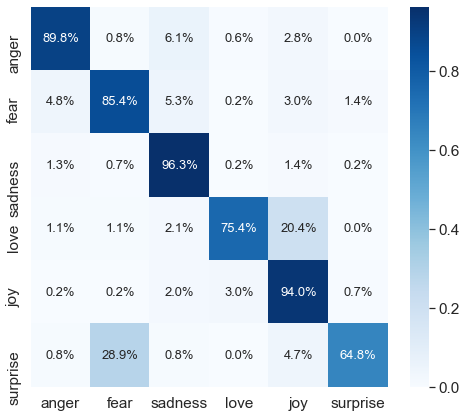

In [93]:
# confusion matrix
plt.figure(figsize=(8,7))
df_cm = pd.DataFrame(confusion_matrix(y_test, svm4_pred, 
                                      labels=["anger", "fear","sadness", "love", "joy","surprise"]),
                    ["anger", "fear","sadness", "love", "joy","surprise"], 
                    ["anger", "fear","sadness", "love", "joy","surprise"])
sns.set(font_scale=1.4)#for label size
# sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap="Blues")
sns.heatmap(df_cm.div(df_cm.sum(axis=1), axis=0), annot=True, 
            fmt='.1%', cmap='Blues',annot_kws={"size": 13})
plt.show()

In [86]:
df_cm

,anger,fear,sadness,love,joy,surprise
anger,457,4,31,3,14,0
fear,21,374,23,1,13,6
sadness,13,7,987,2,14,2
love,3,3,6,211,57,0
joy,3,2,24,36,1147,8
surprise,1,37,1,0,6,83


In [123]:
testing_df[(y_test=='surprise') & (svm4_pred=='joy')]

,sentence,label
3258,feel like amazing co screenwriter roberto orci...,surprise
7511,feel urgency introduce readers amazing touchin...,surprise
7487,im feeling amazing im answering questions new ...,surprise
5400,chose makes feel amazing,surprise
4694,could picture homely feel also smell books wou...,surprise
4376,love sunshine havent much feeling shoulders wa...,surprise


In [125]:
list(df.loc[7511])

['i feel an urgency to introduce readers to the amazing and touching story of anna iya and erik',
 'surprise']

## Fasttext

In [22]:
# Format the data
train_fasttext = training_df.apply(lambda t: '__label__' + str(t['label']) + 
                                   ' ' + str(t['sentence']), axis=1)
test_fasttext = testing_df.apply(lambda t: '__label__' + str(t['label']) + 
                                 ' ' + str(t['sentence']), axis=1)
train_fasttext.to_csv('train_fasttext.txt',index=False, header=False)
test_fasttext.to_csv('test_fasttext.txt',index=False, header=False)

In [75]:
model_ft1 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.1, ws=5, wordNgrams=2, epoch=100)
ft1_pred = model_ft1.test('test_fasttext.txt')

print("precision: ", ft1_pred[1])
print("recall: ", ft1_pred[2])
print("F-1 score: ", 2*ft1_pred[1]*ft1_pred[2]/(ft1_pred[1]+ft1_pred[2]))

In [76]:
model_ft12 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.2, ws=10, wordNgrams=2, epoch=100)
ft2_pred = model_ft12.test('test_fasttext.txt')

print("precision: ", ft2_pred[1])
print("recall: ", ft2_pred[2])
print("F-1 score: ", 2*ft2_pred[1]*ft2_pred[2]/(ft2_pred[1]+ft2_pred[2]))

In [77]:
model_ft13 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.2, ws=10, wordNgrams=2, epoch=300)
ft3_pred = model_ft13.test('test_fasttext.txt')

print("precision: ", ft3_pred[1])
print("recall: ", ft3_pred[2])
print("F-1 score: ", 2*ft3_pred[1]*ft3_pred[2]/(ft3_pred[1]+ft3_pred[2]))

In [78]:
model_ft14 = fasttext.train_supervised('train_fasttext.txt', loss='softmax',
                                      lr=0.2, ws=15, wordNgrams=2, epoch=100)
ft4_pred = model_ft14.test('test_fasttext.txt')
ft4_pred
print("precision: ", ft4_pred[1])
print("recall: ", ft4_pred[2])
print("F-1 score: ", 2*ft4_pred[1]*ft4_pred[2]/(ft4_pred[1]+ft4_pred[2]))

## LSTM

In [27]:
def load_data(file_path): 
    
    df = pd.read_csv(file_path)
    return df



REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):    
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

def process_texts(file_dir: str, is_train: bool) -> None:    
    all_texts = []    
    for file_name in os.listdir(file_dir):        
        if is_train and file_name.startswith('cv9'):            
            continue        
        if not is_train and not file_name.startswith('cv9'):            
            continue        
        file_path = os.path.join(file_dir, file_name)        
        cleaned_text = clean_text(load_text(file_path))
        all_texts.append(cleaned_text)    
    return all_texts

In [28]:
def build_lstm_classifier(X_train, Y_train, X_test, Y_test,
                          MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(13, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
   

In [29]:
file_path = 'data_clean.csv'
df = load_data(file_path) 

df['sentence'] = df['sentence'].apply(clean_text).str.replace('\d+', '')

print(df['sentence']) 

0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
17995    keep feeling like someone unkind wrong think g...
17996    im feeling little cranky negative doctors appo...
17997    feel useful people gives great feeling achieve...
17998    im feeling comfortable derby feel though start...
17999    feel weird meet w people tet like dont talk fa...
Name: sentence, Length: 18000, dtype: object


In [32]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15996 unique tokens.


In [35]:
X = tokenizer.texts_to_sequences(df['sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (18000, 250)


In [36]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (18000, 6)


In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 2020)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(14400, 250) (14400, 6)
(3600, 250) (3600, 6)


In [50]:
def build_lstm_classifier(MAX_NB_WORDS, EMBEDDING_DIM, INPUT_LENGTH=X.shape[1], 
                          NEURONS=100, LR=0.01):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(NEURONS, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [53]:
EPOCHS = 5
BACH_SIZE = 64

model1 = build_lstm_classifier(MAX_NB_WORDS, EMBEDDING_DIM, INPUT_LENGTH=X.shape[1], 
                               NEURONS=100, LR=0.001)

history1 = model1.fit(X_train, Y_train, 
                    epochs=EPOCHS, batch_size=BACH_SIZE,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
None
Train on 12960 samples, validate on 1440 samples
Epoch 1/5
12960/12960 [==============================] - 198s 15ms/step - loss: 1.4015 - accuracy: 0.4650 - val_loss: 0.8104 - val_accuracy: 0.7410
Epoch 2/5
12960/12960 [=================

In [54]:
accr1 = model1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

3600/3600 [==============================] - 24s 7ms/step
Test set
  Loss: 0.320
  Accuracy: 0.901


In [55]:
EPOCHS = 5
BACH_SIZE = 64

model2 = build_lstm_classifier(MAX_NB_WORDS, EMBEDDING_DIM, INPUT_LENGTH=X.shape[1], 
                               NEURONS=200, LR=0.001)

history2 = model2.fit(X_train, Y_train, 
                    epochs=EPOCHS, batch_size=BACH_SIZE,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1206      
Total params: 5,242,006
Trainable params: 5,242,006
Non-trainable params: 0
_________________________________________________________________
None
Train on 12960 samples, validate on 1440 samples
Epoch 1/5
12960/12960 [==============================] - 283s 22ms/step - loss: 1.3548 - accuracy: 0.4838 - val_loss: 0.7915 - val_accuracy: 0.7521
Epoch 2/5
12960/12960 [=================

In [56]:
accr2 = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr2[0],accr2[1]))

3600/3600 [==============================] - 34s 9ms/step
Test set
  Loss: 0.270
  Accuracy: 0.914


In [58]:
EPOCHS = 5
BACH_SIZE = 64

model3 = build_lstm_classifier(MAX_NB_WORDS, EMBEDDING_DIM, INPUT_LENGTH=X.shape[1], 
                               NEURONS=200, LR=0.0005)

history3 = model3.fit(X_train, Y_train, 
                    epochs=EPOCHS, batch_size=BACH_SIZE,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 1206      
Total params: 5,242,006
Trainable params: 5,242,006
Non-trainable params: 0
_________________________________________________________________
None
Train on 12960 samples, validate on 1440 samples
Epoch 1/5
12960/12960 [==============================] - 281s 22ms/step - loss: 1.5566 - accuracy: 0.3782 - val_loss: 1.3793 - val_accuracy: 0.4993
Epoch 2/5
12960/12960 [=================

In [59]:
accr3 = model3.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr3[0],accr3[1]))

3600/3600 [==============================] - 34s 9ms/step
Test set
  Loss: 0.345
  Accuracy: 0.891
